## Введение в анализ данных, ИАД-4

## НИУ ВШЭ, 2019-20 учебный год

### Домашнее задание №2

Задание выполнил(а): Щекотов Иван

### Общая информация

__Дата выдачи:__ 05.03.2020

__Дедлайн:__ 19.03.2020 23:59

### О задании

В этом домашнем задании вы реализуете алгоритм kNN и линейную регрессию, попрактикуетесь в решении задачи регрессии, а также решите теоретические задачи.

### Оценивание и штрафы

Оценка за ДЗ вычисляется по следующей формуле:

$$
\text{points} \times 10 / 18,
$$

где points — количество баллов за обязательную часть, которое вы набрали. Максимальное число баллов, которое можно получить за обязательную часть — 18, а максимальное число дополнительных баллов, которые пойдут в бонус — 2. Бонусные задания отмечены звездочками (*).

За сдачу задания позже срока на итоговую оценку за задание накладывается штраф в размере 1 балл в день, но получить отрицательную оценку нельзя.

__Внимание!__ Домашнее задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов.

### Формат сдачи

Загрузка файлов с решениями происходит в системе [Anytask](https://anytask.org/).

Инвайт для группы ИАД-4: zG1cIyT

Перед отправкой перезагрузите ноутбук и проверьте, что все ячейки могут быть последовательно выполнены. Ноутбук должен запускаться с использованием python 3.6+

# kNN своими руками (5)

В этом задании вам предстоит реализовать взвешенный алгоритм kNN для регрессии. Пусть необходимо вычислить значение $y$ для некоторого $x$ при известных данных $\left(x_1, y_1\right), \ldots, \left(x_\ell, y_\ell\right)$. Предсказанием вашего регрессора будет являться

$$
\hat{y} = \frac{\sum\limits_{i=1}^kw_iy_{(i)}}{\sum\limits_{i=1}^kw_i},
$$
где $\left(x_{(1)}, y_{(1)}\right), \ldots, \left(x_{(k)}, y_{(k)}\right)$ - ближайшие $k$ объектов к $x$ по некоторой метрике $d(\cdot, \cdot)$. Ваш алгоритм должен уметь работать с двумя метриками:

$$
d\left(x_{(i)}, x\right) = \|x_{(i)} - x\|_2 = \sqrt{\sum\limits_{j=1}^n\left(x_{(i)}^j - x^j\right)^2}\qquad\text{(евклидова)}
$$
$$
d\left(x_{(i)}, x\right) = \|x_{(i)} - x\|_1 = \sum\limits_{j=1}^n\left|x_{(i)}^j - x^j\right|\qquad\text{(манхэттена)}
$$

### Реализуйте две функции расстояния (1 балл)
- евклидова метрика **(0.5 балла)**
- метрика Манхэттена **(0.5 балла)**

Обе функции должны на вход получать матрицу `np.array of shape(n, m)` и вектор `np.array of shape(m,)`, а возвращать вектор расстояний от каждой строчки матрицы до вектора `np.array of shape(n,)`

**В данном пункте запрещено использование циклов for, while. Пользуйтесь возможностями numpy.** 

In [1]:
import numpy as np

In [2]:
def euclidian_metric(X, x):
    distances = np.sqrt(np.sum(np.power(np.subtract(X, x), 2), axis=1))
    return distances

def manhattan_metric(X, x):
    distances = np.sum(np.abs(np.subtract(X, x)), axis=1)
    return distances    

In [3]:
# проверка
X = np.array([[1, 2, 3], [5, 6, 7], [8, 9, 10]])
y = np.ones(3)

assert np.allclose(euclidian_metric(X, y), np.array([ 2.23606798,  8.77496439, 13.92838828]))
assert np.allclose(manhattan_metric(X, y), np.array([ 3., 15., 24.]))

### Реализуйте алгоритм kNN для регрессии (4 балла)

- реализуйте класс kNN для равномерных весов (то есть $w_1 = \ldots = w_k$) **(3 балла)**
- добавьте возможность передать данному классу параметр `weights='distance'` для вызова взвешенной версии алгоритма kNN (то есть $w_i = \frac{1}{d\left(x, x_{(i)}\right)}$ **(1 балл)**

Взвешенный knn работает с точностью до одного знака после запятой для k > 1. Для k == 1 assert выполняется.

In [4]:
class KNN:
    def __init__(self, metric="euclid", k=5, weights="uniform"):
        """
        PARAMETERS:
        metric ('euclid' or 'manhattan')
        k - number of nearest neighbors
        """

        self.metric = metric
        self.k = k
        self.weights = weights
        
        self.X_train = None
        self.y_train = None

    def __check_k(self, X_train_rows):
        if self.k > X_train_rows:
            raise Exception("k exceeds maximum possible number: use X_train.shape for reference")
        elif self.k <= 0:
            raise Exception(str(self.k) + " < 0 : expected k > 0")

    def __get_distances_check_metric(self, X_test, y_pred_size):
        if (self.metric == "euclid"):
            dist = np.array([euclidian_metric(self.X_train, X_test[i]) for i in range(y_pred_size)])
        elif self.metric == "manhattan":
            dist = np.array([manhattan_metric(self.X_train, X_test[i]) for i in range(y_pred_size)])
        else:
            raise Exception(self.metric + " is not supported in this knn-extension: choose 'euclid' or 'manhattan' instead")
        return dist

    def __check_edge(self, dist_vec, X_train_rows, y_pred_size):
        if self.k != X_train_rows:
            idx = np.array([np.argpartition(dist_vec[i], self.k) for i in range(y_pred_size)])
        else:
            idx = np.array([np.argsort(dist_vec[i]) for i in range(y_pred_size)])
        return idx

    def __get_weighted_arr(self, y_pred_size, index_partition, dist):
        if self.weights == "uniform":
            gen = np.array([[(self.y_train[index_partition[i][j]] / self.k)
             for j in range(self.k)] for i in range(y_pred_size)])
            gen = np.apply_along_axis(np.sum, 1, gen)
        elif self.weights == "distance":
            dist = np.sort(dist, axis=1)
            dist_sum = np.array([np.sum(dist[i][:self.k]) for i in range(y_pred_size)])
            gen = np.array([[(self.y_train[index_partition[i][j]] * dist[i][j])
             for j in range(self.k)] for i in range(y_pred_size)])
            gen = np.array([np.divide(np.sum(gen[i]), dist_sum[i]) for i in range(y_pred_size)])
        else:
            raise Exception(self.weights +  " is not supported in this knn-extension: choose 'uniform' or 'distance' instead")
        return gen
        
    def fit(self, X_train, y_train):
        """
        INPUT:
        X_train - np.array of shape (n, d)
        y_train - np.array of shape (n,)
        """

        self.X_train = X_train
        self.y_train = y_train
        
    def predict(self, X_test):
        """
        INPUT:
        X_test - np.array of shape (m, d)
        
        OUTPUT:
        y_pred - np.array of shape (m,)
        """
        if self.X_train is None or self.y_train is None:
            raise Exception("Fit the model before use")
        
        self.__check_k(len(X_train))
        y_pred_size = len(X_test)
        dist = self.__get_distances_check_metric(X_test, y_pred_size)
        idx = self.__check_edge(dist, len(X_train), y_pred_size)
        y_pred = self.__get_weighted_arr(y_pred_size, idx, dist)
        return y_pred

Сверьте для нескольких комбинаций различных гиперпараметров свой результат на искусственной выборке с результатом соответствующего алгоритма из `sklearn`. **Не забудьте про гиперпараметр `weights`.**

In [5]:
np.random.seed(13)
X_train = np.random.randn(1000, 50)
y_train = np.random.randn(1000,)
X_test = np.random.randn(500, 50)
y_test = np.random.randn(500,)

In [6]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=1, weights="distance")
knn.fit(X_train, y_train)
knn.predict(X_test)

array([ 1.47817589e+00, -6.25845531e-01, -1.36728666e+00, -1.30991289e-01,
       -1.94949287e-01,  1.69992274e-03,  2.16181995e-03, -5.22782560e-01,
       -5.83678586e-01, -1.94949287e-01,  9.52131087e-01, -1.36728666e+00,
       -6.68652153e-01,  1.10984625e-01,  5.66285019e-02,  8.33520107e-01,
       -3.81386678e-01, -1.27618108e+00, -9.22329290e-01, -2.16565386e+00,
       -2.29928976e+00,  4.58069204e-01,  1.79270404e+00, -1.78106109e+00,
       -1.34831353e-01, -3.68652033e-01,  6.70045969e-01,  8.21726783e-01,
        3.27091692e-01, -1.72550037e-02,  1.69992274e-03, -7.12436924e-01,
       -1.11463686e+00, -3.29532222e-01, -2.01643197e-01, -4.57739461e-01,
        5.14505331e-01, -3.31157793e-01, -1.72550037e-02, -1.48319669e+00,
        2.55523291e-01,  7.67991774e-01, -6.66179379e-02,  1.65559185e+00,
        4.93119623e-01, -1.20325601e+00, -2.60337017e-01, -1.36728666e+00,
       -7.69662783e-01,  5.82326167e-02,  4.93119623e-01, -1.88178065e+00,
       -2.29496010e+00, -

In [7]:
sknn = KNN(k=1, weights="distance")
sknn.fit(X_train, y_train)
sknn.predict(X_test)


array([ 1.47817589e+00, -6.25845531e-01, -1.36728666e+00, -1.30991289e-01,
       -1.94949287e-01,  1.69992274e-03,  2.16181995e-03, -5.22782560e-01,
       -5.83678586e-01, -1.94949287e-01,  9.52131087e-01, -1.36728666e+00,
       -6.68652153e-01,  1.10984625e-01,  5.66285019e-02,  8.33520107e-01,
       -3.81386678e-01, -1.27618108e+00, -9.22329290e-01, -2.16565386e+00,
       -2.29928976e+00,  4.58069204e-01,  1.79270404e+00, -1.78106109e+00,
       -1.34831353e-01, -3.68652033e-01,  6.70045969e-01,  8.21726783e-01,
        3.27091692e-01, -1.72550037e-02,  1.69992274e-03, -7.12436924e-01,
       -1.11463686e+00, -3.29532222e-01, -2.01643197e-01, -4.57739461e-01,
        5.14505331e-01, -3.31157793e-01, -1.72550037e-02, -1.48319669e+00,
        2.55523291e-01,  7.67991774e-01, -6.66179379e-02,  1.65559185e+00,
        4.93119623e-01, -1.20325601e+00, -2.60337017e-01, -1.36728666e+00,
       -7.69662783e-01,  5.82326167e-02,  4.93119623e-01, -1.88178065e+00,
       -2.29496010e+00, -

In [8]:
knn = KNN(metric='euclid')
knn.fit(X_train, y_train)

sknn = KNeighborsRegressor(p=2, weights='uniform')
sknn.fit(X_train, y_train)

assert np.allclose(knn.predict(X_test), sknn.predict(X_test))

In [9]:
#uniform manhattan
knn = KNN(metric='manhattan')
knn.fit(X_train, y_train)

sknn = KNeighborsRegressor(p=1, weights='uniform')
sknn.fit(X_train, y_train)

assert np.allclose(knn.predict(X_test), sknn.predict(X_test))

In [10]:
#weighted euclid
knn = KNN(metric='euclid', weights='distance', k=1)
knn.fit(X_train, y_train)

sknn = KNeighborsRegressor(p=2, weights='distance', n_neighbors=1)
sknn.fit(X_train, y_train)

assert np.allclose(knn.predict(X_test), sknn.predict(X_test))

In [11]:
#weighted manhattan
knn = KNN(metric='manhattan', weights='distance', k=1)
knn.fit(X_train, y_train)

sknn = KNeighborsRegressor(p=1, weights='distance', n_neighbors=1)
sknn.fit(X_train, y_train)

assert np.allclose(knn.predict(X_test), sknn.predict(X_test))

# Линейная регрессия своими руками (5)

Реализуйте линейную регрессию с градиентным спуском для [функции потерь Хьюбера](https://en.wikipedia.org/wiki/Huber_loss):

$$
L_\delta\left(y, \hat{y}\right) =
\begin{cases}
\frac{1}{2}\left(y - \hat{y}\right)^2, \qquad &|y - \hat{y}| \leq \delta\\
\delta\left|y - \hat{y}\right| - \frac{1}{2}\delta^2,\qquad & \text{otherwise}
\end{cases}
$$

В таком случае общее значение функции потерь на всем датасете $(x_1, y_1), \ldots, (x_\ell, y_\ell)$ будет равно

$$
L = \frac{1}{\ell}\sum\limits_{i=1}^\ell L_\delta\left(y_i, \hat{y}_i\right)
$$

*Чему будет равен градиент этой функции по $w$? Вспомните, что за вектор $\hat{y}$ и как он зависит от $X$ и $w$.*

Эти ссылки могут показаться вам полезными:
- https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture02-linregr.pdf
- https://towardsdatascience.com/linear-regression-using-gradient-descent-97a6c8700931
- https://stats.stackexchange.com/questions/312737/mean-absolute-error-mae-derivative

In [12]:
import matplotlib.pyplot as plt

%matplotlib inline

### Реализуйте функцию потерь Хьюбера для одного примера и ее градиент по весам (1.5 балла)

- функция потерь **(0.5 балла)**
- градиент **(1 балл)**

**В данном пункте запрещено использование циклов for, while. Пользуйтесь возможностями numpy. Однако можно использовать оператор if.**

In [13]:
def huber_loss(x, y, w, delta):
    """
    x - np.array shape=(d,)
    y - scalar
    w - np.array shape=(d,)
    delta - scalar
    
    OUTPUT:
    loss - scalar
    """
    y_hat = np.dot(w, x)
    diff_abs = np.abs(y - y_hat)
    if diff_abs <= delta:
        return np.power(diff_abs, 2) / 2
    return delta * diff_abs - np.power(delta, 2) / 2

def huber_grad(x, y, w, delta):
    """
    INPUT:
    x - np.array shape=(d,)
    y - scalar
    w - np.array shape=(d,)
    delta - scalar
    
    OUTPUT:
    grad - np.array shape=(d,)
    """
    y_hat = np.dot(w, x)
    diff_abs = np.abs(y - y_hat)
    diff = y - y_hat
    if diff_abs <= delta:
        return -1 * diff * x
    diff_sgn = 1 if diff >= 0 else -1
    return -1 * x * diff_sgn


In [14]:
# проверка

x = np.array([1, 2, 3])
w = np.array([3, 5, 12])
y = 19
delta = 1

assert huber_loss(x, y, w, delta) == 29.5
assert np.allclose(huber_grad(x, y, w, delta), np.array([1, 2, 3]))

y = 49.2

assert np.allclose(huber_loss(x, y, w, delta), 0.02000000000000057)
assert np.allclose(huber_grad(x, y, w, delta), np.array([-0.2, -0.4, -0.6]))

### Реализуйте линейную регрессию (3.5 балла)

*Вы можете опустить единичный признак в модели и не добавлять его в данные. Для данной искусственной выборки это не актуально, потому что целевая переменная в этом случае является случайной величиной из стандартного нормального распределения со средним 0.*

*Вектор весов в градиентном спуске можете инициализировать нулями.*

Вместо функций calc_gradient и calc_loss я написал свои приватные методы.

In [15]:
class LinearRegressionHuber:
    def __init__(self, delta=1.0, max_iter=1000, tol=1e-6, eta=1e-2):
        """
        PARAMETERS:
        delta - scalar in Huber loss
        max_iter - maximum possible number of iterations in Gradient Descent
        tol - precision for stopping criterion in Gradient Descent
        eta - step size in Gradient Descent (learning rate)
        """

        self.delta = delta
        self.max_iter = max_iter
        self.tol = tol
        self.eta = eta
        
        self.w = None
        self.loss_history = None
        
    def __get_cum_loss(self, X, y, shape):
        h_loss = 0
        for i in range(shape[0]):
            h_loss += huber_loss(X[i], y[i], self.w, self.delta)
        h_loss /= shape[0]
        return h_loss

    def __get_cum_grad(self, X, y, shape):
        grad = np.zeros(shape[1])
        for i in range(shape[0]):
            grad += huber_grad(X[i], y[i], self.w, self.delta)
        grad /= shape[0]
        return grad

    def fit(self, X, y):
        """
        INPUT:
        X_train - np.array of shape (n, d)
        y_train - np.array of shape (n,)
        
        В этой функции вы должны инициализировать веса (можно нулями), а также 
        итерационно обновлять веса с помощью 
        градиентного спуска (считать и запоминать лосс (значение функции потерь) будет хорошим решением)
        """

        shape = X.shape
        self.w = np.zeros(X.shape[1])
        self.loss_history = []
        for iter in range(self.max_iter):
            cumulative_loss = self.__get_cum_loss(X, y, shape)
            self.loss_history.append(cumulative_loss)
            gradient = self.__get_cum_grad(X, y, shape)
            self.w = self.w - self.eta * gradient

            if cumulative_loss < self.tol:
                return np.array(self.loss_history)

        return np.array(self.loss_history)
        
    def predict(self, X):
        """
        INPUT:
        X_test - np.array of shape (m, d)
        
        OUTPUT:
        y_pred - np.array of shape (m,)
        
        Предскажите ответы с помощью обученных весов
        """
        return np.dot(X, self.w)

Проверьте работу вашего метода: выведите результаты его работы на той же искусственной выборке, что и в задаче выше (в качестве метрик качества используйте MSE и Huber loss). Постройте график зависимости значения функции потерь от итерации градиентного спуска.

In [16]:
from sklearn.metrics import mean_squared_error

In [17]:
#linear regression (Huber)
lrh = LinearRegressionHuber()
loss_history = lrh.fit(X_train, y_train)
lrh_predict = lrh.predict(X_test)

In [18]:
#linear regression
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)


In [19]:
#mse comparison

print("huber:", mean_squared_error(lrh_predict, y_test), "\nlin_reg(sklearn):", mean_squared_error(lr_pred, y_test))

huber: 1.1624739218664648 
lin_reg(sklearn): 1.1640531058089234


In [20]:
import matplotlib.pyplot as plt

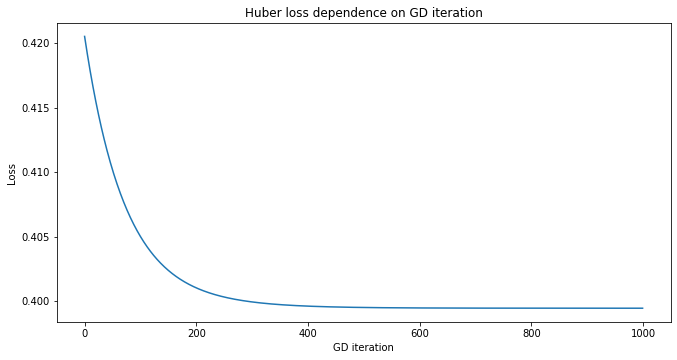

In [21]:
plt.figure(figsize=(11, 5.5))
plt.title("Huber loss dependence on GD iteration")
plt.xlabel("GD iteration")
plt.ylabel("Loss")
plt.plot(loss_history)
plt.show()

# Практика (8 + 0.5*)

Пожалуйста, при использовании различных функций из библиотек импортируйте все, что вам понадобилось в данной части, в следующем блоке:

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.feature_selection import VarianceThreshold, SelectKBest, SelectFromModel, f_regression
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures

%matplotlib inline

В этой части вы поработаете с данными из другого соревнования на Kaggle: https://www.kaggle.com/c/house-prices-advanced-regression-techniques. Задача - предсказание цены дома.

In [23]:
data = pd.read_csv('train.csv', header=0)
pd.set_option('display.max_rows', 500)
pd.set_option('max_colwidth', 800)

In [24]:
data.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [25]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [26]:
data.drop('Id', axis=1, inplace=True)

## 1 (1)

Есть ли в данных пропуски? Если да, то для каждого столбца, в котором они имеются, посчитайте их количество и их долю от общего числа значений. Что вы наблюдаете?

In [27]:
#missing values count
count = data.isnull().sum().sort_values(ascending=False)

#percent
percent =(data.isnull().sum() / data.isnull().count()).sort_values(ascending=False)
missing_values_table = pd.concat([count, percent], axis=1, keys=["Count", "Percent"])
missing_values_table.head(19)

,Count,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageType,81,0.055479
GarageCond,81,0.055479
GarageFinish,81,0.055479
GarageQual,81,0.055479


Можно заметить, что в 19 колонках находятся пропущенные значения. Таким образом, видя процент от всех значений в столбце, можно определить имеет ли смысл восстанавливать какие-либо данные или можно просто отбросить признак, и он не будет полезен для анализа. Так, первые 4 значения можно уверенно отбросить(что я сделаю в начале следующего задания).

## 2 (1)

Избавьтесь от пропусков. Для каждого из примененных методов обоснуйте свое решение. **Проверьте, что вы действительно избавились от пропусков.**

*Напоминание. В зависимости от типа столбца, можно заполнить пропуски, например, средним арифметическим, медианой, модой, можно какими-то отдельными значениями. А можно такие столбцы вообще удалить.*

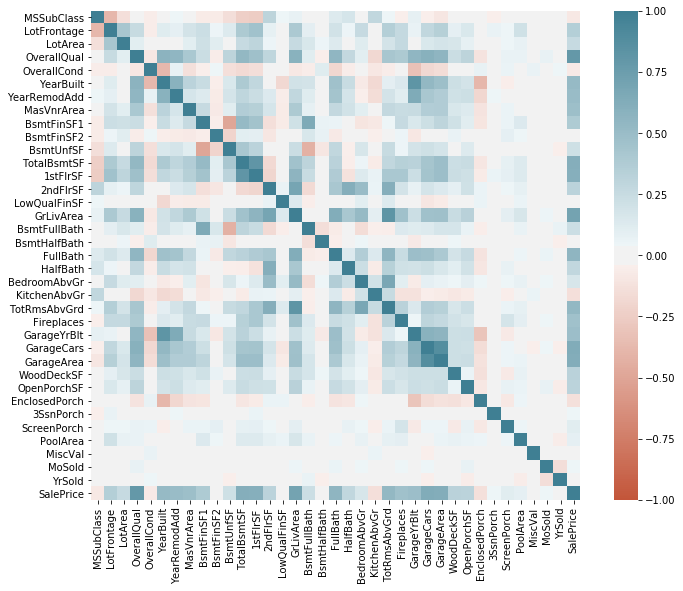

In [28]:
corr = data.corr()
plt.subplots(figsize=(12, 9))
sns.heatmap(corr, vmin=-1, vmax=1, cmap=sns.diverging_palette(20, 220, n=256), center=0, square=True)
plt.show()

PoolQc, MiscFeature, Alley, Fence содержат более 80 процентов пропусков. Поэтому их можно удалить. Самые основные характеристики относительно гаража содержатся в признаке GarageCars (сильная корреляция между признаками Garage...), поэтому их тоже можно удалить как несодержательные. То же самое наблюдается с переменными, начинающимися на bsmt...
MasVnrType и MasVnrArea имеют сильную корреляцию с YearBuilt и OverallQual, поэтому мы ничего не потеряем при анализе, если не будем их учитывать. Одно значение, пропущенное в признаке "Electrical" можно просто удалить, не удаляя при это весь столбец. LotFrontage коррелирует с LotArea. FireplaceQu коррелирует с GrLivArea.

In [29]:
#удаляем пропущенные данные
data = data.drop((missing_values_table[missing_values_table["Count"] > 1]).index,1)
data = data.drop(data.loc[data['Electrical'].isnull()].index)
data.isnull().sum().max()

0

## 3 (1)

Обработайте категориальные признаки. В их обнаружении вам может помочь синтаксис `pandas` (например, можно обратить внимание на типы столбцов), а также описание датасета и его исследование. Объясните выбор метода (one-hot-encoding, label encoding, ...)

In [30]:
# your code here
data = pd.get_dummies(data)

## 4 (0.5)

Вычислите и визуализируйте попарную корреляцию Пирсона между всеми признаками. Какие выводы можно сделать?

*Для визуализации можно использовать `seaborn.heatmap()`.*

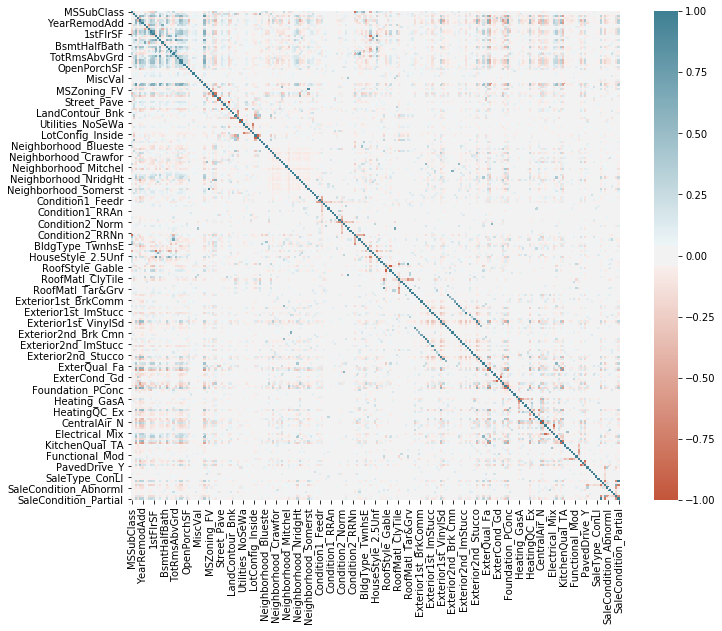

In [31]:
# сделано на одном из предыдущих шагов (с учетом кодирования матрица будет выглядет следующим образом)
corr = data.corr()
plt.subplots(figsize=(12, 9))
sns.heatmap(corr, vmin=-1, vmax=1, cmap=sns.diverging_palette(20, 220, n=256), center=0, square=True)
plt.show()

## 5 (0.5)

Найдите признаки с максимальным и минимальным **абсолютным** значением коэффициента корреляции Пирсона с предсказываемым значением. Изобразите на графиках зависимость найденных признаков от предсказываемого значения.

*Не забудьте указать название графика и обозначить, что изображено по каждой из осей.*

In [32]:
(np.abs(data.corr()["SalePrice"])).sort_values()

RoofMatl_Metal           0.000307
RoofStyle_Mansard        0.000316
Foundation_Wood          0.002706
Condition2_RRAe          0.002990
BldgType_TwnhsE          0.003771
LotConfig_Corner         0.004091
Condition1_RRNe          0.004580
RoofMatl_Tar&Grv         0.004911
Condition1_RRAn          0.005877
LotConfig_FR2            0.006880
RoofMatl_ClyTile         0.006900
BsmtFinSF2               0.011412
ExterCond_Ex             0.011658
Foundation_Stone         0.012110
Utilities_NoSeWa         0.014317
Utilities_AllPub         0.014317
SaleType_ConLI           0.014364
RoofMatl_Roll            0.014482
Condition2_RRAn          0.014514
Neighborhood_SawyerW     0.014537
SaleCondition_Alloca     0.015536
Functional_Mod           0.016085
RoofStyle_Flat           0.016423
Exterior2nd_Stone        0.016761
BsmtHalfBath             0.016873
Functional_Sev           0.017120
Exterior1st_Plywood      0.017753
LotConfig_FR3            0.018180
Neighborhood_Blmngtn     0.019053
SaleType_CWD  

<Figure size 792x396 with 0 Axes>

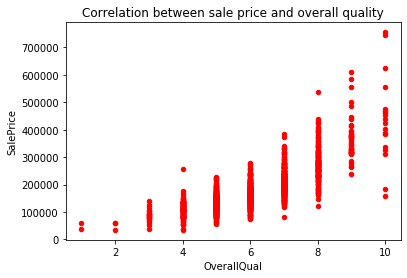

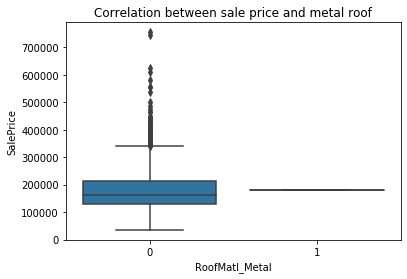

In [33]:
plt.figure(figsize=(11, 5.5))
data.plot.scatter(x = "OverallQual", y = "SalePrice", c = "red", title = 'Correlation between sale price and overall quality')
plt.show()
sns.boxplot(x = "RoofMatl_Metal", y = "SalePrice", data=data).set_title('Correlation between sale price and metal roof')
plt.show()

Материал, из которого сделана крыша, не является важным признаком для предсказания цены дома

## 6 (0.5)

Постройте гистограмму распределения предсказываемого значения. Для избавления от разницы в масштабах, а также "смещения" распределения переменной в сторону нормального (что бывает полезно при статистическом анализе), можно прологарифмировать ее (это обратимое преобразование, поэтому целевую переменную легко восстановить). В данном случае воспользуйтесь `numpy.log1p`, чтобы сделать преобразование $y \to \ln\left(1 + y\right)$. Постройте гистограмму распределения от нового предсказываемого значения. Опишите наблюдения.

*В дальнейшем используйте в качестве предсказываемого значения вектор, который получился после логарифмирования.*

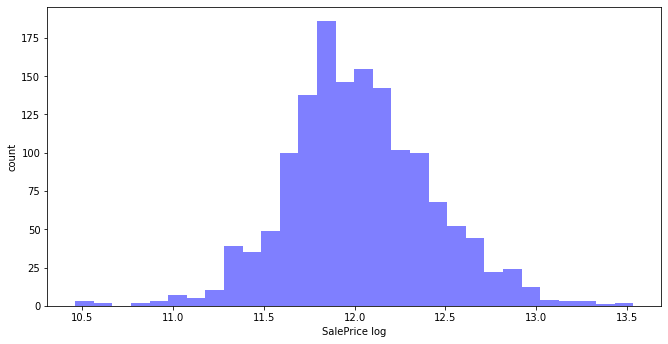

In [35]:
plt.figure(figsize = (11, 5.5))
plt.hist(np.log1p(data.SalePrice), bins=30, alpha=0.5, histtype='stepfilled', color='blue');
plt.xlabel('SalePrice log')
plt.ylabel('count')
plt.show()

Логарифмированные значения более приближены к нормальному распределению (преобразование Бокса-Мюллера)

Перейдем непосредственно к построению моделей. Разобьем выборку на обучение и контроль.

*Пожалуйста, **не меняйте** значение `random_state` в следующей ячейке.*

In [36]:
X_train, X_val, y_train, y_val = train_test_split(
    data.drop('SalePrice', axis=1),
    np.log1p(data['SalePrice']),
    random_state=13
)

In [37]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((1094, 220), (365, 220), (1094,), (365,))

## 7 (2)

Примените к данным следующие алгоритмы:

- kNN
- линейная регрессия
- Lasso
- Ridge

Для каждого из методов подберите гиперпараметры с помощью кросс-валидации. Обучите алгоритмы с лучшими гиперпараметрами на обучающей выборке и оцените качество по метрике **Root** Mean Squared Error. Какой из методов показывает себя лучше?

KNN

In [38]:
# KNN
knn = KNeighborsRegressor()
knn.fit(X_train, y_train)
y_pred = knn.predict(X_val)
rmse_knn = mean_squared_error(y_val, y_pred, squared=False)
rmse_knn

0.23375456143096285

In [39]:
#knn-tuned
params = {'p': [1, 2], "n_neighbors": range(1, 10, 1), "weights": ["uniform", "distance"]}
grid_search = GridSearchCV(KNeighborsRegressor(), param_grid=params, cv=5)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
y_pred = grid_search.predict(X_val)
rmse_grid_knn = mean_squared_error(y_val, y_pred, squared=False)
rmse_grid_knn

{'n_neighbors': 8, 'p': 1, 'weights': 'distance'}


0.22068327098715382

Linear Regression

In [40]:
lin_reg = LinearRegression()
params = {"fit_intercept": ["True", "False"]}
grid_search = GridSearchCV(lin_reg, params, cv=5)
grid_search.fit(X_train, y_train)
y_pred = grid_search.predict(X_val)
lin_reg_coef = grid_search.best_estimator_.coef_
print(grid_search.best_params_)
rmse_lin_reg = mean_squared_error(y_val, y_pred, squared=False)
rmse_lin_reg

{'fit_intercept': 'True'}


0.1557292186157219

Lasso

In [41]:
params = {'alpha':np.linspace(0.0001, 1, 1000), 'fit_intercept': ['True', 'False']}
grid_search = GridSearchCV(Lasso(), params, cv=5)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
lasso_coef = grid_search.best_estimator_.coef_
y_pred = grid_search.predict(X_val)
rmse_lasso = mean_squared_error(y_val, y_pred, squared=False)
rmse_lasso

{'alpha': 0.0001, 'fit_intercept': 'True'}


0.15011258241654518

Ridge

In [42]:
params = {'alpha': np.linspace(0.0001, 50, 1000), 'fit_intercept': ['True', 'False']}
grid_search = GridSearchCV(Ridge(), params, cv=10)
grid_search.fit(X_train, y_train)
y_pred = grid_search.predict(X_val)
print(grid_search.best_params_)
ridge_coef = grid_search.best_estimator_.coef_
rmse_ridge = mean_squared_error(y_val, y_pred, squared=False)
rmse_ridge

{'alpha': 14.764835235235234, 'fit_intercept': 'True'}


0.1490808392390834

## 8 (1)

Постройте гистограммы значений весов для линейной регрессии, Lasso и Ridge. Опишите наблюдения. В чем различия между полученными наборами весов и почему?

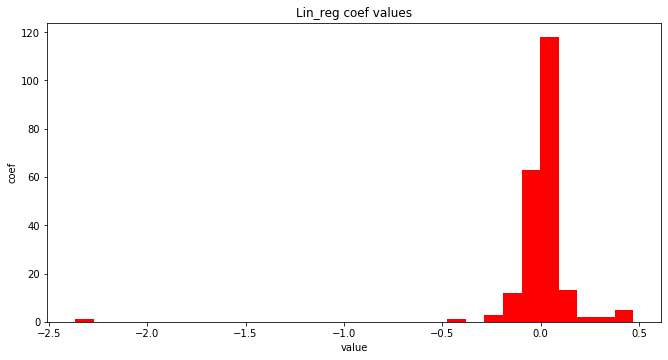

In [43]:
plt.figure(figsize = (11, 5.5))
plt.hist(lin_reg_coef, bins=30, alpha=1,
         histtype='stepfilled', color='red',
         edgecolor='none');
plt.xlabel('value')
plt.title("Lin_reg coef values")
plt.ylabel('coef')
plt.show()

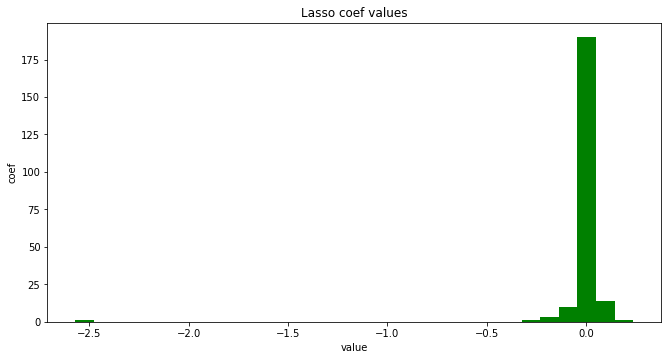

In [44]:
plt.figure(figsize = (11, 5.5))
plt.hist(lasso_coef, bins=30, alpha=1,
         histtype='stepfilled', color='green',
         edgecolor='none');
plt.xlabel('value')
plt.title("Lasso coef values")
plt.ylabel('coef')
plt.show()

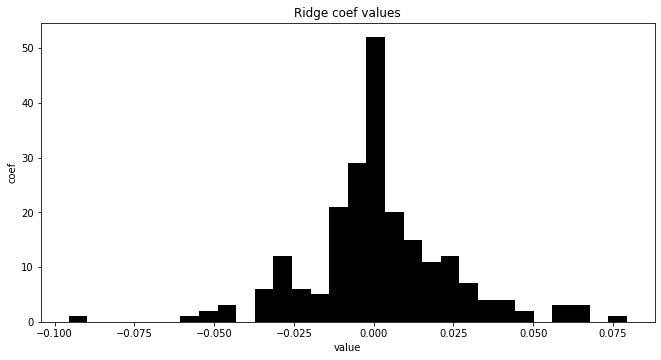

In [45]:
plt.figure(figsize = (11, 5.5))
plt.hist(ridge_coef, bins=30, alpha=1,
         histtype='stepfilled', color='black',
         edgecolor='none');
plt.xlabel('value')
plt.title("Ridge coef values")
plt.ylabel('coef')
plt.show()

## 9 (0.5)

Добейтесь того, чтобы в заданиях выше ваш лучший алгоритм давал качество не больше 0.212 на валидации по метрике RMSE (если вы дошли до этого задания, а качество выше уже удовлетворяет этому условию, вы автоматически получите за него полный балл).

In [46]:
# your code here

## 10* (0.5)

Добейтесь того, чтобы в заданиях выше ваш лучший алгоритм давал качество не больше 0.210 на валидации по метрике RMSE. Для этого вы можете использовать самые разные методы, какие захотите - отбор признаков, генерация новых, разные способы предобработки данных. Единственное ограничение - не использовать никакие алгоритмы регрессии, кроме kNN, линейной регрессии, Lasso и Ridge.

In [47]:
# your code here

# Теория (1.5*)

За данную часть можно получить бонусные баллы. Решения необходимо оформить в этом же файле в ячейках типа Markdown, пользуясь $\LaTeX$ для записи математических формул.

## 1* (0.5)

Найдите константу $C$, решающую следующую задачу ($0 < \tau < 1$ фиксировано):

$$
\sum\limits_{i=1}^\ell\rho_\tau\left(y_i - C\right) \to \min_C,
$$

где

$$
\rho_\tau(z) =
\begin{cases}
\tau z, & z > 0\\
(\tau - 1)z, & z \leq 0
\end{cases}
$$

*(your solution here)*

## 2* (0.5)

Алгоритм регрессии выдает константный ответ для любого объекта: $a(x) = C$. Найдите $C$, при котором средняя абсолютная ошибка на обучающей выборке $\{(x_1, y_1), \ldots, (x_\ell, y_\ell)\}$ будет минимальной.

*(your solution here)*

## 3* (0.5)

Гарри Поттер хочет найти философский камень, расположенный в точке минимума функции $f(x_1, x_2)=x_1^2 + x_2^2$. В момент времени 0 он стартует из точки $x^{(0)}=(2, 2)$. На $i$-й минуте Гарри мгновенно перемещается (аппарирует) из точки $x^{(i)}$ в точку

$$
x^{(i+1)} = x^{(i)} - \eta \nabla f(x^{(i)}),
$$

где $\nabla f(x^{(i)})$ — градиент $f$ в точке $x^{(i)}$, $\eta \ge 0$ — фиксированное число. Опишите судьбу Гарри в зависимости от значения $\eta$. При каких значениях $\eta$ Гарри подойдёт к философскому камню сколь угодно близко? Сколько итераций ему понадобится, чтобы подойти к философскому камню на расстояние не больше $\varepsilon$?

*(your solution here)*